In [1]:
import heeps
from heeps.pupil.create_lyotstop import create_ls
from heeps.util.img_processing import resize_img, pad_img
from heeps.util.multiCPU import multiCPU
from copy import deepcopy
import proper
from scipy.interpolate import interp2d
from astropy.io import fits
import astropy.convolution as astroconv
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

### Inputs

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))
maskM1 = fits.getdata('eso/mask_fullM1.fits')
spiders = fits.getdata('eso/SpiderShadow.fits')
nimg = 10526                # size of the high-res pupil image
phot_spiders_L = 3.5        # pixels on the spiders (for 1 inside the pupil)
phot_spiders_N = 4.3
phot_envirnt_L = 4.3        # pixels outside the pupil (for 1 inside the pupil)
phot_envirnt_N = 5.1
spi_width = 0.54            # spider width in m
pupil_img_size = 39.9988    # pupil image in m
# nominal diameters
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
# METIS diameters in mm
diam_nominal_METIS = 28
pupil_img_size_METIS = diam_nominal_METIS*pupil_img_size/diam_nominal_ext
print('pupil_img_size_METIS = %.2f mm'%pupil_img_size_METIS)
# Huygens PSF data
data = 'pupil_blurring/LMS_3_worstcase_pp7.txt'
data_spacing = 0.014239     # in mm
# 2D map
npup = 31
nspi = 31
rp = np.linspace(0, 0.06, npup)
rs = np.linspace(0, 0.06, nspi)

pupil_img_size_METIS = 29.06 mm


### Initialize wavefront using PROPER

In [3]:
conf = dict(
    band = 'L',
    mode = 'ELT',
    dir_output = 'input_files/pupil/pupil_blurring',
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_lyot_stop = '',
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf) 
wf = heeps.pupil.pupil(savefits=True, norm_I=False, verbose=True, **conf)

Simulation config: band=L, mode=ELT
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)

Load pupil from 'ELT_fullM1.fits'


### Background thermal emission

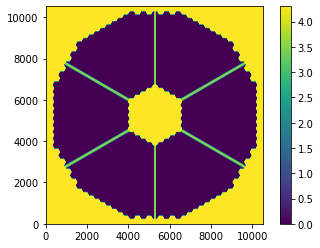

In [4]:
filename = 'pupil_blurring/background_emission_L.fits'
if os.path.isfile(filename):
    pup = fits.getdata(filename)
else:
    pup = maskM1*((1 - spiders)*phot_spiders_L) + (1 - maskM1)*phot_envirnt_L
    fits.writeto(filename, pup, overwrite=True)
plt.imshow(pup, origin='lower'); plt.colorbar();

### Define functions

In [5]:
def blurred_pupil(data):
    # 1/ load kernel (Huygens PSF)
    filename = 'pupil_blurring/LMS_kernel.fits'
    if os.path.isfile(filename):
        kernel = fits.getdata(filename)
    else:
        kernel = np.loadtxt(data, delimiter='\t', encoding='utf-16', skiprows=21)
        kernel = np.delete(kernel, 0, 0)
        kernel = np.delete(kernel, 0, 1)
        fits.writeto(filename, kernel, overwrite=True)
    nkernel = kernel.shape[0]
    kernel_size = nkernel*data_spacing
    plt.imshow(np.log10(kernel), origin='lower'); plt.colorbar()
    print('nkernel = %s, kernel_size = %.2f mm'%(nkernel, kernel_size))
    # 2/ convolve: pupil image (log scale) with all-glass limits marked
    npupil_conv = int(np.ceil(nkernel*pupil_img_size_METIS/kernel_size))
    filename = 'pupil_blurring/LMS_pup_conv.fits'
    if os.path.isfile(filename):
        pup_conv = fits.getdata(filename)
    else:
        pup_conv = astroconv.convolve(resize_img(pup, npupil_conv), kernel, boundary='extend')
        fits.writeto(filename, pup_conv, overwrite=True)
    _, ax = plt.subplots()
    c = pup_conv.shape[0]/2
    ax.add_patch(plt.Circle((c,c), c/pupil_img_size*diam_allglass_ext, color='red', fill=False))
    ax.add_patch(plt.Circle((c,c), c/pupil_img_size*diam_allglass_int, color='red', fill=False))
    plt.imshow(np.log10(pup_conv), origin='lower'); plt.colorbar()
    plt.clim(0, -6)
    plt.savefig('pupil_blurring/LMS_pup_conv_log_scale.png', dpi=300, transparent=True)
    print('npupil_conv = %s'%npupil_conv)
    # 3/ resize to npupil
    pup_conv = resize_img(pup_conv, conf['npupil'])
    return pup_conv

def flux_thruput(pup_conv, r_pup, r_spi):
    # create lyot stop
    conf.update(ls_dRext=r_pup, ls_dRint=r_pup, ls_dRspi=r_spi)
    ls = create_ls(diam_allglass_ext, diam_allglass_int, 
            circ_ext=False, circ_int=False, **conf)
    # background flux
    overlay = pup_conv*ls
    flux = np.nansum(overlay)
    # throughput
    wf1 = deepcopy(wf)
    proper.prop_multiply(wf1, pad_img(ls, conf['ngrid']))
    thruput = np.sum(proper.prop_get_amplitude(wf1))
    return flux, thruput

def multi_flux_thruput(pup_conv):
    if os.path.isfile('pupil_blurring/LMS_flux.fits'):
        flux = fits.getdata('pupil_blurring/LMS_flux.fits')
        thruput = fits.getdata('pupil_blurring/LMS_thruput.fits')
    else:
        flux, thruput = multiCPU(flux_thruput, posargs=[pup_conv],
            posvars=[np.repeat(rp, nspi), np.tile(rs, npup)], nout=2)
        flux = flux.reshape(npup, nspi)
        thruput = thruput.reshape(npup, nspi)
        fits.writeto('pupil_blurring/LMS_flux.fits', flux)
        fits.writeto('pupil_blurring/LMS_thruput.fits', thruput)
    return flux, thruput

def fmt(x):
    x = 10**(x+2)
    s = f"{x:.3f}"
    if s.endswith("0"):
        s = f"{x:.2f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

def plot_rel_flux(flux, thruput):
    # fraction of background flux relative to flux from pupil
    rel_flux = flux/thruput
    _, ax = plt.subplots(figsize = (8,6))
    plt.imshow(np.log10(rel_flux), origin='lower', aspect='auto', cmap='viridis', 
        extent=(rs[0],rs[-1],rp[0],rp[-1]))
    plt.colorbar()

    f_flux = interp2d(rs, rp, rel_flux)
    f_thru = interp2d(rs, rp, thruput)
    
    x_opt, y_opt = 0.0317, 0.0291
    flux_opt = 0.0374/100
    print('flux_opt = %.4f%%'%(flux_opt*100))

    CS = ax.contour(np.log10(rel_flux), [np.log10(flux_opt), -3, -2], 
        colors='magenta', linewidths=2, linestyles=[':','-','-'], 
        extent=(rs[0],rs[-1],rp[0],rp[-1]))
    lx = []
    ly = []
    for c in CS.collections:
        v = c.get_paths()[0].vertices
        x = v[:,0]
        y = v[:,1]
        t = np.array([f_thru(s,p) for s,p in zip(x,y)])
        j = np.argmax(t)
        plt.scatter(x[j], y[j], s=150, c='magenta', marker='+')
        print('max thruput = (%.2f%%, %.2f%%)'%(x[j]*100, y[j]*100))
        lx.append(x[j]+5e-3)
        ly.append(y[j]-5e-3)

    manual = np.array([lx,ly]).T
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=12, 
        manual=manual)

    plt.scatter(x_opt, y_opt, s=150, c='red', marker='+')
    plt.ylabel('ls_dRext & ls_dRint (%)');
    plt.xlabel('ls_dRspi (%)');
    plt.title('Relative flux \n ');
    ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
    ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
    plt.savefig('pupil_blurring/LMS_rel_flux.png', dpi=300, transparent=True)

### LMS_3_worstcase_pp7.txt

nkernel = 127, kernel_size = 1.81 mm
npupil_conv = 2041


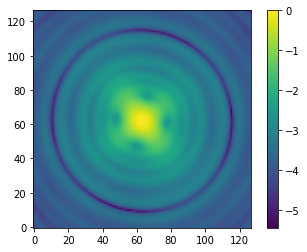

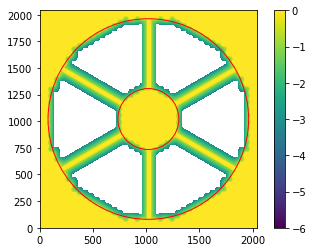

In [6]:
pup_conv = blurred_pupil(data)

In [7]:
flux, thruput = multi_flux_thruput(pup_conv)

flux_opt = 0.0374%
max thruput = (5.13%, 5.40%)
max thruput = (4.25%, 4.20%)
max thruput = (1.40%, 1.21%)


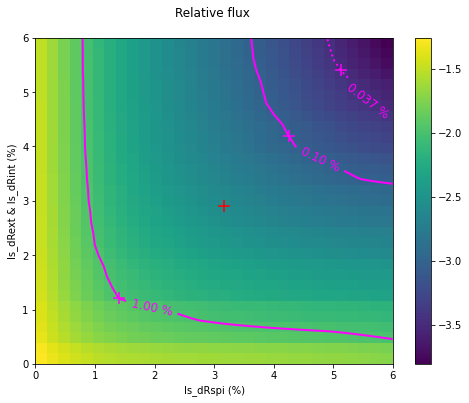

In [8]:
plot_rel_flux(flux, thruput)